In [4]:

from transformers import AutoImageProcessor, AutoModel  # ADDED [use AutoModel backbone]
# from transformers import AutoModelForImageClassification  # COMMENTED OUT: replaced by AutoModel backbone
from PIL import Image
import requests
import pandas as pd
import os
from tqdm.auto import tqdm
import glob
import multiprocessing as mp
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torchviz import make_dot
from ptflops import get_model_complexity_info
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')


Running on device: cuda:0


# Training Data

In [5]:
train_dir = 'D:\\W\\VS\\VS Folder\\DFD\\DFDC MTCNN Extracted\\'
train_df = pd.read_csv(os.path.join(train_dir, 'metadata.csv'))
train_df['path'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x.split('.')[0]))

# Remove empty folders
train_df = train_df[train_df['path'].map(lambda x: os.path.exists(x))]
train_df

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aag...
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aap...
2,abarnvbtwb.mp4,REAL,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aba...
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abo...
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abq...
...,...,...,...,...,...
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\ete...
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\etm...
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\eto...
398,eudeqjhdfd.mp4,REAL,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\eud...


In [6]:
valid_train_df = pd.DataFrame(columns=['filename', 'label', 'split', 'original', 'path'])

# for row_idx, row in tqdm(train_df.iterrows()):
for row_idx in tqdm(train_df.index):
    row = train_df.loc[row_idx]
    img_dir = row['path']
    face_paths = glob.glob(f'{img_dir}/*.png')

    if len(face_paths) >= 5: # Satisfy the minimum requirement for the number of faces
        face_indices = [
            path.split('\\')[-1].split('.')[0].split('_')[0]
            for path in face_paths
        ]
        max_idx = np.max(np.array(face_indices, dtype=np.uint32))

        selected_paths = []

        for i in range(5):
            stride = int((max_idx + 1)/(5**2))
            sample = np.linspace(i*stride, max_idx + i*stride, 5).astype(int)

            # Get faces
            for idx in sample:
                paths = glob.glob(f'{img_dir}/{idx}*.png')

                selected_paths.extend(paths)
                if len(selected_paths) >= 5: # Get enough faces
                    break

            if len(selected_paths) >= 5:  # Get enough faces
                valid_train_df = pd.concat([valid_train_df, pd.DataFrame([row])], ignore_index=True)
                break

  0%|          | 0/400 [00:00<?, ?it/s]

In [7]:
valid_train_df['label']=valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0})
display(valid_train_df.head())

label_count = valid_train_df.groupby('label').count()['filename']
print(label_count)

x = valid_train_df['path'].to_numpy()
y = valid_train_df['label'].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=224, stratify=y)

np.savez('train_test_split.npz',
         x_train=x_train,
         x_val=x_val,
         y_train=y_train,
         y_val=y_val)

C:\Users\rachi\AppData\Local\Temp\ipykernel_8608\3380636837.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valid_train_df['label']=valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0})


,filename,label,split,original,path
0,aagfhgtpmv.mp4,1,train,vudstovrck.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aag...
1,aapnvogymq.mp4,1,train,jdubbvfswz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aap...
2,abarnvbtwb.mp4,0,train,NaN,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aba...
3,abqwwspghj.mp4,1,train,qzimuostzz.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\abq...
4,acifjvzvpm.mp4,1,train,kbvibjhfzo.mp4,D:\W\VS\VS Folder\DFD\DFDC MTCNN Extracted\aci...


label
0     76
1    306
Name: filename, dtype: int64


# Training - Feature extraction and classifier

In [8]:
data = np.load('train_test_split.npz', allow_pickle=True)
x_train = data['x_train']
y_train = data['y_train']

### Model

In [9]:
processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# model = AutoModelForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224", num_labels=1, ignore_mismatched_sizes=True)  # COMMENTED OUT
# ADDED: load Swin backbone to get hidden states (features) per frame
model = AutoModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")  # ADDED
hidden_size = model.config.hidden_size  # ADDED: feature size for LSTM input

# ADDED: temporal head (BiLSTM + Linear -> 1 logit)
temporal_lstm = nn.LSTM(
    input_size=hidden_size,   # from Swin hidden size
    hidden_size=512,
    num_layers=2,
    batch_first=True,
    bidirectional=True,
    dropout=0.1).to(device)  # ADDED

temporal_head = nn.Linear(512 * 2, 1).to(device)  # ADDED

# classifier = nn.Linear(768, 1)
criterion = nn.BCEWithLogitsLoss(reduction='none')  # For binary classification


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
print(model)
print(temporal_lstm)
print(temporal_head)


SwinModel(
  (embeddings): SwinEmbeddings(
    (patch_embeddings): SwinPatchEmbeddings(
      (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    )
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): SwinEncoder(
    (layers): ModuleList(
      (0): SwinStage(
        (blocks): ModuleList(
          (0): SwinLayer(
            (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attention): SwinAttention(
              (self): SwinSelfAttention(
                (query): Linear(in_features=96, out_features=96, bias=True)
                (key): Linear(in_features=96, out_features=96, bias=True)
                (value): Linear(in_features=96, out_features=96, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): SwinSelfOutput(
                (dense): Linear(in_features=96, out_features=96, bias=True)
            

In [11]:

model = model.to(device)
model.train()
temporal_lstm.train()   # ADDED
temporal_head.train()   # ADDED

# freeze model parameters
for param in model.parameters():
    param.requires_grad = False

print(len(model.encoder.layers),"total layers")

# unfreeze n layer parameters
n = 1
for layer in model.encoder.layers[-n:]:
    for param in layer.parameters():
        param.requires_grad = True
    display(f'Unfreezing layer: {layer}')

# for param in model.classifier.parameters():
#     param.requires_grad = True

# UPDATED: optimize unfrozen Swin encoder params + temporal head params (LSTM + head)
optimizer = torch.optim.Adam(
    # list(model.classifier.parameters()) +   # COMMENTED OUT
    [p for p in model.encoder.parameters() if p.requires_grad]  # keep unfrozen encoder params
    + list(temporal_lstm.parameters())  # ADDED
    + list(temporal_head.parameters()), # ADDED
    lr=1e-4
)






4 total layers


'Unfreezing layer: SwinStage(\n  (blocks): ModuleList(\n    (0): SwinLayer(\n      (layernorm_before): LayerNorm((768,), eps=1e-05, elementwise_affine=True)\n      (attention): SwinAttention(\n        (self): SwinSelfAttention(\n          (query): Linear(in_features=768, out_features=768, bias=True)\n          (key): Linear(in_features=768, out_features=768, bias=True)\n          (value): Linear(in_features=768, out_features=768, bias=True)\n          (dropout): Dropout(p=0.0, inplace=False)\n        )\n        (output): SwinSelfOutput(\n          (dense): Linear(in_features=768, out_features=768, bias=True)\n          (dropout): Dropout(p=0.0, inplace=False)\n        )\n      )\n      (drop_path): SwinDropPath(p=0.09090909361839294)\n      (layernorm_after): LayerNorm((768,), eps=1e-05, elementwise_affine=True)\n      (intermediate): SwinIntermediate(\n        (dense): Linear(in_features=768, out_features=3072, bias=True)\n        (intermediate_act_fn): GELUActivation()\n      )\n    

### Train

In [ ]:


if os.path.exists('swin_tiny_lstm.pth'):
    print("Loading existing model weights...")
    state = torch.load('swin_tiny_lstm.pth', map_location='cpu')
    # UPDATED: handle both old single-module checkpoints and new dict checkpoints
    

    model.load_state_dict(state['backbone'], strict=False)        # UPDATED
    temporal_lstm.load_state_dict(state['temporal_lstm'])         # ADDED
    temporal_head.load_state_dict(state['temporal_head'])         # ADDED
    optimizer.load_state_dict(state['optimizer'])

    model = model.to(device)
    temporal_lstm = temporal_lstm.to(device)                           # ADDED
    temporal_head = temporal_head.to(device)                           # ADDED
    
    print("Resuming training with loaded model weights.")
else:
    print("Model weights not found, starting training...")


    

batch_size = 16
labels = []
video_paths = x_train
video_labels = y_train
total_batches = 0



num_epochs = 20  # Adjust as needed

train_loss = np.zeros(num_epochs)

start_time = time.time()

epoch_bar = tqdm(range(num_epochs), desc='Epochs')
for epoch in epoch_bar:
    model.train()
    # classifier.train()
    temporal_lstm.train()   # ADDED
    temporal_head.train()   # ADDED

    running_loss = 0.0
    total_batches = 0

    videos_processed = 0  # ADDED

    video_bar = tqdm(zip(video_paths, video_labels),desc='Videos', total=len(video_paths))
    for path, label in video_bar:
        image_files = sorted([ os.path.join(path, f)
        for f in os.listdir(path)
        if f.lower().endswith('.png')
        ])

        labels.extend([label] * len(image_files))  # Repeat label for each image

        video_run_loss=0.0
        batches = 0

        # ADDED: collect per-frame embeddings for the whole video
        frame_feats = []  # ADDED

        for i in range(0, len(image_files), batch_size):
            batch_paths = image_files[i:i+batch_size]
            images = [Image.open(p).convert("RGB") for p in batch_paths]
            inputs = processor(images=images, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs, output_hidden_states=False, return_dict=True)  # ADDED
            
            last_hidden = outputs.last_hidden_state  # (B, S, C)  # ADDED
            pooled = last_hidden.mean(dim=1)         # (B, C)     # ADDED
            frame_feats.append(pooled)  # ADDED

            batches += 1
            total_batches += 1

        # ADDED: assemble sequence and run LSTM head to get a single logit per video

        if len(frame_feats) > 0:
            seq = torch.cat(frame_feats, dim=0)               # (T, C)     # ADDED
            seq = seq.unsqueeze(0)                            # (1, T, C)  # ADDED

            optimizer.zero_grad()                             # ADDED
            lstm_out, _ = temporal_lstm(seq)                  # (1, T, H*2) # ADDED
            last = lstm_out[:, -1, :]                         # (1, H*2)    # ADDED
            video_logit = temporal_head(last)                 # (1, 1)      # ADDED

            video_label = torch.tensor([[label]], dtype=torch.float, device=device)  # (1,1)  # ADDED
            loss = criterion(video_logit, video_label)        # (1,1) with reduction='none'   # ADDED
            loss = loss.mean()                                # scalar for backward            # ADDED
            loss.backward()                                   # ADDED
            optimizer.step()                                  # ADDED

            loss_item = loss.item()                           # ADDED
            running_loss += loss_item                         # ADDED
            video_run_loss += loss_item                       # ADDED

            videos_processed += 1                              # ADDED

        video_loss = video_run_loss
        video_bar.set_postfix(Last_Loss=f'{video_loss:.4f}')

    avg_loss = running_loss / videos_processed if videos_processed > 0 else 0  # UPDATED
    train_loss[epoch] = avg_loss
    epoch_bar.set_postfix(Curr_Loss=f'{avg_loss:.4f}')

end_time = time.time()
training_time = end_time - start_time

# Save model backbone and temporal head
torch.save({
    'backbone': model.state_dict(),          # UPDATED
    'temporal_lstm': temporal_lstm.state_dict(),  # ADDED
    'temporal_head': temporal_head.state_dict(),   # ADDED
    'optimizer': optimizer.state_dict()
}, 'swin_tiny_lstm.pth')

# Saving training loss

if os.path.exists('swin_tiny_lstm_train_loss.npy'):
    # loading existing training loss
    training_loss = np.load('swin_tiny_lstm_train_loss.npy')
    training_loss = np.concatenate((training_loss, train_loss))
    np.save('swin_tiny_lstm_train_loss.npy', training_loss)

else:
    training_loss = train_loss
    np.save('swin_tiny_lstm_train_loss.npy', training_loss)






Model weights not found, starting training...


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Videos:   0%|          | 0/267 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
print(inputs["pixel_values"].shape)
print(f"Training completed in {training_time/60:.2f} minutes")


torch.Size([12, 3, 224, 224])
Training completed in 261.07 minutes


Log Loss Graph

In [1]:
epochs = list(range(1, len(training_loss) + 1))
plt.figure(figsize=(16, 8))
plt.plot(epochs, training_loss)
plt.title('Training Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Log Loss')
plt.show()


NameError: name 'training_loss' is not defined

# Validation

In [ ]:
model.load_state_dict(torch.load('swin_tiny_lstm.pth'))
# classifier.load_state_dict(torch.load('vit_classifier_head.pth'))
model = model.to(device)
# classifier = classifier.to(device)



### Model and Data

In [5]:
data = np.load('train_test_split.npz', allow_pickle=True)
x_val = data['x_val']
y_val = data['y_val']


In [6]:
batch_size = 24
video_paths = x_val
video_labels = y_val
labels = []
val_preds= []
probabs = []
losses = []

model.eval()
# classifier.eval()

running_loss = 0.0
total_batches = 0
total_images = 0
correct = 0
total = 0

start_time = time.time()

video_bar = tqdm(zip(video_paths, video_labels),desc='Videos', total=len(video_paths))
for path, label in video_bar:
    image_files = sorted([ os.path.join(path, f)
    for f in os.listdir(path)
    if f.lower().endswith('.png')
    ])

    labels.extend([label] * len(image_files))  # Repeat label for each image
    total_images += len(image_files)

    for i in tqdm(range(0, len(image_files), batch_size), desc='Image Batches', leave=False):
        total_batches += 1
        batch_paths = image_files[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]
        inputs = processor(images=images, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        batch_labels = torch.tensor([label] * len(images), dtype=torch.float).unsqueeze(1).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            batch_logits = outputs.logits

            # running_loss += criterion(batch_logits, batch_labels).item()* batch_labels.size(0)
            loss = criterion(batch_logits, batch_labels).detach().cpu().view(-1).tolist()
            losses.extend(loss)

            prob=torch.sigmoid(batch_logits).detach().cpu().view(-1).tolist()
            probabs.extend(prob)

            preds = (torch.sigmoid(batch_logits) > 0.5).int()
            correct += (preds == batch_labels.int()).sum().item()
            total += batch_labels.size(0)

accuracy = correct / total if total > 0 else 0

# val_loss = running_loss / total_batches if total_batches > 0 else 0
val_loss = sum(losses) / total if total > 0 else 0

end_time = time.time()
vali_time = end_time - start_time
vali_inf_time = vali_time / total_images
vali_fps = total_images / vali_time






Videos:   0%|          | 0/115 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/26 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Image Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
print(f"Validation Accuracy: {accuracy*100:.2f}%")
print(f"Validation Log Loss: {val_loss:.4f}")

print(f"Validation Time: {vali_time/60:.2f} minutes")
print(f"Validation Single Inference Time: {vali_inf_time:.2f} seconds")
print(f"Validation FPS: {vali_fps:.2f} images/second")


Validation Accuracy: 85.27%
Validation Log Loss: 1.0583
Validation Time: 8.06 minutes
Validation Single Inference Time: 0.01 seconds
Validation FPS: 80.00 images/second


Text(1.5, 1.2, 'TF')

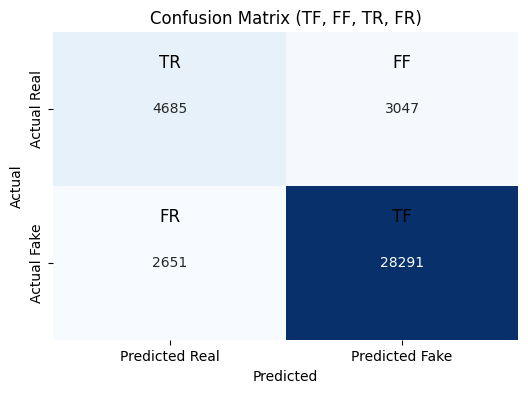

In [8]:
cm = confusion_matrix([int(x) for x in labels], [1 if p > 0.5 else 0 for p in probabs])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Real", "Predicted Fake"],
            yticklabels=["Actual Real", "Actual Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (TF, FF, TR, FR)")

# Labels for clarity (optional)
plt.text(0.5, 0.2, "TR", ha="center", va="center", color="black", fontsize=12)
plt.text(1.5, 0.2, "FF", ha="center", va="center", color="black", fontsize=12)
plt.text(0.5, 1.2, "FR", ha="center", va="center", color="black", fontsize=12)
plt.text(1.5, 1.2, "TF", ha="center", va="center", color="black", fontsize=12)

In [9]:
CFR=0
CFF=0

for i in range(len(labels)):
    if labels[i]==1 :
        if probabs[i] < 0.3:
            CFR+=1
    else:
        if probabs[i] > 0.7:
            CFF+=1

print(f"Confident False Real: {CFR}")
print(f"Confident False Fake: {CFF}")

Confident False Real: 2352
Confident False Fake: 2903


Measuring Gflops

In [46]:


# Replace this with your actual model instance
input_shape = (3, 224, 224)  # Typical for ViT, adjust as needed

macs, params = get_model_complexity_info(
    model, input_shape, as_strings=False, print_per_layer_stat=True, backend='aten'
)

print(f"FLOP: {2*macs/1000000000:.2f} GFLOP")
print(f"Params: {params/1000000:.2f} M")

Total:4.5 GMac
Module:  Global
aten.convolution: 14.75 MMac
aten.addmm: 4.17 GMac
aten.bmm: 140.14 MMac
aten.mm: 173.41 MMac

Module:  swin
aten.convolution: 14.75 MMac
aten.addmm: 4.17 GMac
aten.bmm: 140.14 MMac
aten.mm: 173.41 MMac

Module:  classifier
aten.addmm: 769 Mac

FLOP: 9.01 GFLOP
Params: 14.18 M


In [47]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params / 1e6:.2f}M")

Total parameters: 27.52M


In [48]:
from thop import profile
input_tensor = torch.randn(1, 3, 224, 224).to(device)
tmacs, tparams = profile(model, inputs=(input_tensor,))
print(f"Params: {tparams / 1e6:.2f}M, GFLOPs: {2*tmacs / 1e9:.2f}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
Params: 27.50M, GFLOPs: 8.73


# Old Codes Ignore

In [ ]:
# # === Imports and setup (unchanged unless noted) ===
# import os, time, numpy as np, torch
# import torch.nn as nn
# from PIL import Image
# from tqdm import tqdm

# # ADDED: import AutoModel to access backbone features instead of classification logits
# from transformers import AutoImageProcessor, AutoModel  # ADDED [use AutoModel backbone]
# # from transformers import AutoModelForImageClassification  # COMMENTED OUT: replaced by AutoModel backbone

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # === Data ===
# data = np.load('train_test_split.npz', allow_pickle=True)
# x_train = data['x_train']
# y_train = data['y_train']

# # === Processor ===
# # Stays the same to ensure correct resize/normalization for the Swin checkpoint
# processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")  # unchanged

# # === Model / Backbone ===
# # COMMENTED OUT: classification head version (we will use the backbone to get features for LSTM)
# # model = AutoModelForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224", num_labels=1, ignore_mismatched_sizes=True)  # COMMENTED OUT

# # ADDED: load Swin backbone to get hidden states (features) per frame
# model = AutoModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")  # ADDED
# hidden_size = model.config.hidden_size  # ADDED: feature size for LSTM input

# # ADDED: temporal head (BiLSTM + Linear -> 1 logit)
# temporal_lstm = nn.LSTM(
#     input_size=hidden_size,   # from Swin hidden size
#     hidden_size=512,
#     num_layers=2,
#     batch_first=True,
#     bidirectional=True,
#     dropout=0.1
# ).to(device)  # ADDED

# temporal_head = nn.Linear(512 * 2, 1).to(device)  # ADDED

# # Keep BCEWithLogitsLoss; we will reduce manually after computing the per-video loss
# criterion = nn.BCEWithLogitsLoss(reduction='none')  # unchanged

# model = model.to(device)
# model.train()
# temporal_lstm.train()   # ADDED
# temporal_head.train()   # ADDED

# # === Freezing / unfreezing ===
# # Freeze everything first (backbone only; temporal head stays trainable)
# for param in model.parameters():
#     param.requires_grad = False  # unchanged (applies to backbone)

# # Diagnostic: number of encoder layers in Swin
# print(len(model.swin.encoder.layers), "total layers")  # unchanged (SwinModel still exposes .swin.encoder.layers)

# # Unfreeze last n encoder layers
# n = 1
# for layer in model.swin.encoder.layers[-n:]:
#     for param in layer.parameters():
#         param.requires_grad = True
#     display(f'Unfreezing layer: {layer}')  # unchanged

# # COMMENTED OUT: there is no classifier anymore in the backbone model
# # for param in model.classifier.parameters():
# #     param.requires_grad = True  # COMMENTED OUT

# # === Optimizer ===
# # UPDATED: optimize unfrozen Swin encoder params + temporal head params (LSTM + head)
# optimizer = torch.optim.Adam(
#     # list(model.classifier.parameters()) +   # COMMENTED OUT
#     [p for p in model.swin.encoder.parameters() if p.requires_grad]  # keep unfrozen encoder params
#     + list(temporal_lstm.parameters())  # ADDED
#     + list(temporal_head.parameters()), # ADDED
#     lr=1e-4
# )

# # === Checkpoint ===
# if os.path.exists('swin_tiny_lstm.pth'):
#     print("Loading existing model weights...")
#     state = torch.load('swin_tiny_lstm.pth', map_location='cpu')
#     # UPDATED: handle both old single-module checkpoints and new dict checkpoints
#     if isinstance(state, dict) and 'backbone' in state and 'temporal_lstm' in state and 'temporal_head' in state:
#         model.load_state_dict(state['backbone'], strict=False)        # UPDATED
#         temporal_lstm.load_state_dict(state['temporal_lstm'])         # ADDED
#         temporal_head.load_state_dict(state['temporal_head'])         # ADDED
#     else:
#         # Backward-compat: prior single-module weights
#         model.load_state_dict(state, strict=False)                     # UPDATED
#     model = model.to(device)
#     temporal_lstm = temporal_lstm.to(device)                           # ADDED
#     temporal_head = temporal_head.to(device)                           # ADDED
#     print("Resuming training with loaded model weights.")
# else:
#     print("Model weights not found, starting training...")

# # === Training hyperparams ===
# batch_size = 16
# labels = []
# video_paths = x_train
# video_labels = y_train
# total_batches = 0

# num_epochs = 20  # unchanged

# train_loss = np.zeros(num_epochs)

# start_time = time.time()

# epoch_bar = tqdm(range(num_epochs), desc='Epochs')
# for epoch in epoch_bar:
#     model.train()
#     temporal_lstm.train()   # ADDED
#     temporal_head.train()   # ADDED

#     running_loss = 0.0
#     total_batches = 0

#     video_bar = tqdm(zip(video_paths, video_labels), desc='Videos', total=len(video_paths))
#     for path, label in video_bar:
#         image_files = sorted([
#             os.path.join(path, f)
#             for f in os.listdir(path)
#             if f.lower().endswith('.png')
#         ])

#         labels.extend([label] * len(image_files))  # unchanged

#         video_run_loss = 0.0
#         batches = 0

#         # ADDED: collect per-frame embeddings for the whole video
#         frame_feats = []  # ADDED

#         for i in range(0, len(image_files), batch_size):
#             batch_paths = image_files[i:i+batch_size]
#             images = [Image.open(p).convert("RGB") for p in batch_paths]
#             inputs = processor(images=images, return_tensors="pt")
#             inputs = {k: v.to(device) for k, v in inputs.items()}

#             # COMMENTED OUT: classification logits per frame (we now extract features)
#             # outputs = model(**inputs)                               # COMMENTED OUT
#             # batch_logits = outputs.logits                           # COMMENTED OUT

#             # ADDED: forward through backbone to get last_hidden_state and pool tokens
#             with torch.no_grad():  # backbone can stay mostly frozen; gradients not needed here unless fine-tuning
#                 outputs = model(**inputs, output_hidden_states=False, return_dict=True)  # ADDED
#                 # Swin returns last_hidden_state of shape (B, seq_len, hidden_size); mean-pool over tokens
#                 last_hidden = outputs.last_hidden_state  # (B, S, C)  # ADDED
#                 pooled = last_hidden.mean(dim=1)         # (B, C)     # ADDED
#             frame_feats.append(pooled.detach())          # ADDED

#             batches += 1
#             total_batches += 1

#         # ADDED: assemble sequence and run LSTM head to get a single logit per video
#         if len(frame_feats) > 0:
#             seq = torch.cat(frame_feats, dim=0)               # (T, C)     # ADDED
#             seq = seq.unsqueeze(0)                            # (1, T, C)  # ADDED

#             optimizer.zero_grad()                             # ADDED
#             lstm_out, _ = temporal_lstm(seq)                  # (1, T, H*2) # ADDED
#             last = lstm_out[:, -1, :]                         # (1, H*2)    # ADDED
#             video_logit = temporal_head(last)                 # (1, 1)      # ADDED

#             video_label = torch.tensor([[label]], dtype=torch.float, device=device)  # (1,1)  # ADDED
#             loss = criterion(video_logit, video_label)        # (1,1) with reduction='none'   # ADDED
#             loss = loss.mean()                                # scalar for backward            # ADDED
#             loss.backward()                                   # ADDED
#             optimizer.step()                                  # ADDED

#             loss_item = loss.item()                           # ADDED
#             running_loss += loss_item                         # ADDED
#             video_run_loss += loss_item                       # ADDED

#         video_loss = video_run_loss / max(1, batches) if batches > 0 else 0
#         video_bar.set_postfix(Last_Loss=f'{video_loss:.4f}')

#     avg_loss = running_loss / max(1, total_batches)
#     train_loss[epoch] = avg_loss
#     epoch_bar.set_postfix(Curr_Loss=f'{avg_loss:.4f}')

# end_time = time.time()
# training_time = end_time - start_time

# # === Save checkpoint ===
# # UPDATED: save both backbone and temporal head
# torch.save({
#     'backbone': model.state_dict(),          # UPDATED
#     'temporal_lstm': temporal_lstm.state_dict(),  # ADDED
#     'temporal_head': temporal_head.state_dict()   # ADDED
# }, 'swin_tiny_lstm.pth')

# # === Save training loss (unchanged) ===
# if os.path.exists('swin_tiny_train_loss.npy'):
#     training_loss = np.load('swin_tiny_train_loss.npy')
#     training_loss = np.concatenate((training_loss, train_loss))
#     np.save('swin_tiny_train_loss.npy', training_loss)
# else:
#     training_loss = train_loss
#     np.save('swin_tiny_train_loss.npy', training_loss)


In [ ]:
# batch_size = 24
# video_paths = x_val
# video_labels = y_val
# labels = []
# val_preds= []
# probabs = []
# losses = []

# model.eval()
# # classifier.eval()

# running_loss = 0.0
# total_batches = 0
# total_images = 0
# correct = 0
# total = 0

# start_time = time.time()

# video_bar = tqdm(zip(video_paths, video_labels),desc='Videos', total=len(video_paths))
# for path, label in video_bar:
#     image_files = sorted([ os.path.join(path, f)
#     for f in os.listdir(path)
#     if f.lower().endswith('.png')
#     ])

#     labels.extend([label] * len(image_files))  # Repeat label for each image
#     total_images += len(image_files)

#     for i in tqdm(range(0, len(image_files), batch_size), desc='Image Batches', leave=False):
#         total_batches += 1
#         batch_paths = image_files[i:i+batch_size]
#         images = [Image.open(p).convert("RGB") for p in batch_paths]
#         inputs = processor(images=images, return_tensors="pt")
#         inputs = {k: v.to(device) for k, v in inputs.items()}

#         batch_labels = torch.tensor([label] * len(images), dtype=torch.float).unsqueeze(1).to(device)

#         with torch.no_grad():
#             outputs = model(**inputs)
#             batch_logits = outputs.logits

#             # running_loss += criterion(batch_logits, batch_labels).item()* batch_labels.size(0)
#             loss = criterion(batch_logits, batch_labels).detach().cpu().view(-1).tolist()
#             losses.extend(loss)

#             prob=torch.sigmoid(batch_logits).detach().cpu().view(-1).tolist()
#             probabs.extend(prob)

#             preds = (torch.sigmoid(batch_logits) > 0.5).int()
#             correct += (preds == batch_labels.int()).sum().item()
#             total += batch_labels.size(0)

# accuracy = correct / total if total > 0 else 0

# # val_loss = running_loss / total_batches if total_batches > 0 else 0
# val_loss = sum(losses) / total if total > 0 else 0

# end_time = time.time()
# vali_time = end_time - start_time
# vali_inf_time = vali_time / total_images
# vali_fps = total_images / vali_time




